In [70]:
import torch
import numpy as np 
import os
import sys
import numba as nb
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_swiss_roll, make_moons, make_circles
import ot

os.chdir('/home/baly/projects/linear_opt')

#from lib.library import *
from lib.lib_ot import *
from lib.lib_lopt import *
#from lib.lib_shape import *


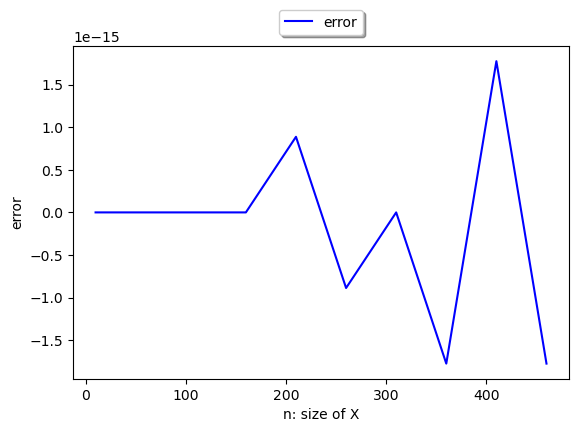

In [2]:
# test correctness

Lambda=5.0
step_size=50
k=1
n_list=np.array(range(10,500,step_size))
opt_cost1=np.zeros((n_list.shape[0],k))
opt_cost2=np.zeros((n_list.shape[0],k))

for i in range(n_list.shape[0]):
    n=n_list[i]
    for k_p in range(k):
        X0=np.random.uniform(-20,20,(n,2))+15
        X1=np.random.uniform(-20,20,(n,2))+0
        X2=np.random.uniform(-20,20,(n,2))+30

        p0=np.ones(n)/n
        p1=np.ones(n)/n
        p2=np.ones(n)/n
        cost1,plan1,penualty1=opt_lp(X0,X1,p0,p1,Lambda,numItermax=200000)
        opt_cost1[i,k_p]=cost1+penualty1
        U0=np.zeros((n,2))
        M0=0.0
        p0_hat=p0
        U1,p1_hat,M1=lopt_embedding(X0,X1,p0,p1,Lambda)
        cost2,penualty2=lopt(U1,U0,p1_hat,p0_hat,Lambda,M1,M0)
#        cost2=np.sum((U1.T)**2*p1_hat)
#        penualty2=Lambda*(np.sum(np.abs(p0-p1_hat))+M1)
        
        opt_cost2[i,k_p]=cost2+penualty2

#        Vi,p0_Ti=linear_embedding(Xi,X0,p1,p0,Lambda)
#        Vj,p0_Tj=linear_embedding(Xj,X0,p2,p0,Lambda)
#        Vij,p0_Tij=vector_plus(Vi,-Vj,p0_Ti,p0_Tj)
#        cost2,penualty2=vector_norm(Vij,p0_Tij,1,Lambda)
#        opt_cost2[i,k_p]=cost2+penualty2
        # if cost2+penualty2<cost1+penualty1-0.00001:
            #     print('error')
            #     print('cost2',cost2)
    #     print('cost1',cost1)
    #     print('penualty1',penualty1)
    #     print('penualty2',penualty2)
    #     break



fig = plt.figure()
ax = plt.subplot(111)
error=opt_cost2-opt_cost1
error_mean=error.mean(1)
error_std=error.std(1)

plt.plot(n_list,error_mean,'-',c='blue',label='error')
plt.fill_between(n_list,error_mean-1*error_std,error_mean+1*error_std,alpha=0.3)

plt.xlabel("n: size of X")
plt.ylabel("error")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.13),
          fancybox=True, shadow=True, ncol=3)
#plt.savefig('experiment/test/results/accuracy_error'+str(Lambda)+'.png',format="png",dpi=800,bbox_inches='tight')
plt.show()



# for i in range(n_list.shape[0]):
#     n=n_list[i]
#     mass=(n-5)/n
#     for k_p in range(k):
#         X0=np.random.uniform(-20,20,(n,2))+15
#         Xi=np.random.uniform(-20,20,(n,2))+0
#         Xj=np.random.uniform(-20,20,(n,2))+30
#         p0=np.ones(n)/n
#         p1=np.ones(n)/n
#         p2=np.ones(n)/n
# #        print('start')
#         cost1,plan1=opt_pr(X0,Xi,p0,p1,mass,numItermax=200000)
# #        print('end')
#         opt_cost1[i,k_p]=cost1
#         Ui,p1_hat=lopt_embedding_pr(X0,Xi,p0,p1,mass)
#         cost2=vector_norm(Ui,p1_hat)
#         opt_cost2[i,k_p]=cost2

# #        Vi,p0_Ti=linear_embedding(Xi,X0,p1,p0,Lambda)
# #        Vj,p0_Tj=linear_embedding(Xj,X0,p2,p0,Lambda)
# #        Vij,p0_Tij=vector_plus(Vi,-Vj,p0_Ti,p0_Tj)
# #        cost2,penualty2=vector_norm(Vij,p0_Tij,1,Lambda)
# #        opt_cost2[i,k_p]=cost2+penualty2
#         # if cost2+penualty2<cost1+penualty1-0.00001:
#             #     print('error')
#             #     print('cost2',cost2)
#     #     print('cost1',cost1)
#     #     print('penualty1',penualty1)
#     #     print('penualty2',penualty2)
#     #     break



# fig = plt.figure()
# ax = plt.subplot(111)
# error=opt_cost2-opt_cost1
# error_mean=error.mean(1)
# error_std=error.std(1)

# plt.plot(n_list,error_mean,'-',c='blue',label='error')
# plt.fill_between(n_list,error_mean-1*error_std,error_mean+1*error_std,alpha=0.3)

# plt.xlabel("n: size of X")
# plt.ylabel("error")
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
# plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.13),
#           fancybox=True, shadow=True, ncol=3)
# #plt.savefig('experiment/test/results/accuracy_error'+str(Lambda)+'.png',format="png",dpi=800,bbox_inches='tight')
# plt.show()

# cost_list={}
# cost_list['cost_v2_list']=cost_v2_list
# cost_list['cost_v2a_list']=cost_v2a_list 
# cost_list['cost_pr_list']=cost_pr_list
# cost_list['cost_lp_list']=cost_lp_list

# torch.save(cost_list,'experiment/test/results/accuracy_list'+str(Lambda)+'.pt')

    

In [3]:
def ot_barycenter(measures_locations, measures_weights, X_init, b=None, weights=None, numItermax=10000,
                            stopThr=1e-7, numThreads=1):
    r"""
    Solves the free support (locations of the barycenters are optimized, not the weights) Wasserstein barycenter problem (i.e. the weighted Frechet mean for the 2-Wasserstein distance), formally:

    .. math::
        \min_\mathbf{X} \quad \sum_{i=1}^N w_i W_2^2(\mathbf{b}, \mathbf{X}, \mathbf{a}_i, \mathbf{X}_i)

    where :

    - :math:`w \in \mathbb{(0, 1)}^{N}`'s are the barycenter weights and sum to one
    - the :math:`\mathbf{a}_i \in \mathbb{R}^{k_i}` are the empirical measures weights and sum to one for each :math:`i`
    - the :math:`\mathbf{X}_i \in \mathbb{R}^{k_i, d}` are the empirical measures atoms locations
    - :math:`\mathbf{b} \in \mathbb{R}^{k}` is the desired weights vector of the barycenter

    This problem is considered in :ref:`[1] <references-free-support-barycenter>` (Algorithm 2).
    There are two differences with the following codes:

    - we do not optimize over the weights
    - we do not do line search for the locations updates, we use i.e. :math:`\theta = 1` in
      :ref:`[1] <references-free-support-barycenter>` (Algorithm 2). This can be seen as a discrete
      implementation of the fixed-point algorithm of
      :ref:`[2] <references-free-support-barycenter>` proposed in the continuous setting.

    Parameters
    ----------
    measures_locations : list of N (k_i,d) array-like
        The discrete support of a measure supported on :math:`k_i` locations of a `d`-dimensional space
        (:math:`k_i` can be different for each element of the list)
    measures_weights : list of N (k_i,) array-like
        Numpy arrays where each numpy array has :math:`k_i` non-negatives values summing to one
        representing the weights of each discrete input measure

    X_init : (k,d) array-like
        Initialization of the support locations (on `k` atoms) of the barycenter
    b : (k,) array-like
        Initialization of the weights of the barycenter (non-negatives, sum to 1)
    weights : (N,) array-like
        Initialization of the coefficients of the barycenter (non-negatives, sum to 1)

    numItermax : int, optional
        Max number of iterations
    stopThr : float, optional
        Stop threshold on error (>0)
    verbose : bool, optional
        Print information along iterations
    log : bool, optional
        record log if True
    numThreads: int or "max", optional (default=1, i.e. OpenMP is not used)
        If compiled with OpenMP, chooses the number of threads to parallelize.
        "max" selects the highest number possible.


    Returns
    -------
    X : (k,d) array-like
        Support locations (on k atoms) of the barycenter


    .. _references-free-support-barycenter:
    References
    ----------
    .. [1] Cuturi, Marco, and Arnaud Doucet. "Fast computation of Wasserstein barycenters." International Conference on Machine Learning. 2014.

    .. [2]  Álvarez-Esteban, Pedro C., et al. "A fixed-point approach to barycenters in Wasserstein space." Journal of Mathematical Analysis and Applications 441.2 (2016): 744-762.

    """

    #nx = get_backend(*measures_locations,*measures_weights,X_init)

    iter_count = 0

    N = len(measures_locations)
    k = X_init.shape[0]
    d = X_init.shape[1]
    # if b is None:
    #     b = nx.ones((k,),type_as=X_init) / k
    # if weights is None:
    #     weights = nx.ones((N,),type_as=X_init) / N

    X = X_init

    # log_dict = {}
    displacement_square_norms = []

    displacement_square_norm = stopThr + 1.

    while (displacement_square_norm > stopThr and iter_count < numItermax):
        T_sum = np.zeros((k, d))
        for (measure_locations_i, measure_weights_i, weight_i) in zip(measures_locations, measures_weights,  weights):
            M_i = cost_matrix_d(X, measure_locations_i)
            T_i = ot.emd(b, measure_weights_i, M_i, numThreads=numThreads)
            T_sum = T_sum + weight_i * 1. / b[:,None] * np.dot(T_i, measure_locations_i)
        displacement_square_norm = np.sum((T_sum - X)**2)
        X = T_sum
        iter_count += 1


    return X


In [4]:
def opt_barycenter(measures_locations, measures_weights, X_init, b, weights,Lambda, numItermax=10000,
                            stopThr=1e-7, numThreads=1):
    r"""
    Solves the free support (locations of the barycenters are optimized, not the weights) Wasserstein barycenter problem (i.e. the weighted Frechet mean for the 2-Wasserstein distance), formally:

    .. math::
        \min_\mathbf{X} \quad \sum_{i=1}^N w_i W_2^2(\mathbf{b}, \mathbf{X}, \mathbf{a}_i, \mathbf{X}_i)

    where :

    - :math:`w \in \mathbb{(0, 1)}^{N}`'s are the barycenter weights and sum to one
    - the :math:`\mathbf{a}_i \in \mathbb{R}^{k_i}` are the empirical measures weights and sum to one for each :math:`i`
    - the :math:`\mathbf{X}_i \in \mathbb{R}^{k_i, d}` are the empirical measures atoms locations
    - :math:`\mathbf{b} \in \mathbb{R}^{k}` is the desired weights vector of the barycenter

    This problem is considered in :ref:`[1] <references-free-support-barycenter>` (Algorithm 2).
    There are two differences with the following codes:

    - we do not optimize over the weights
    - we do not do line search for the locations updates, we use i.e. :math:`\theta = 1` in
      :ref:`[1] <references-free-support-barycenter>` (Algorithm 2). This can be seen as a discrete
      implementation of the fixed-point algorithm of
      :ref:`[2] <references-free-support-barycenter>` proposed in the continuous setting.

    Parameters
    ----------
    measures_locations : list of N (k_i,d) array-like
        The discrete support of a measure supported on :math:`k_i` locations of a `d`-dimensional space
        (:math:`k_i` can be different for each element of the list)
    measures_weights : list of N (k_i,) array-like
        Numpy arrays where each numpy array has :math:`k_i` non-negatives values summing to one
        representing the weights of each discrete input measure

    X_init : (k,d) array-like
        Initialization of the support locations (on `k` atoms) of the barycenter
    b : (k,) array-like
        Initialization of the weights of the barycenter (non-negatives, sum to 1)
    weights : (N,) array-like
        Initialization of the coefficients of the barycenter (non-negatives, sum to 1)

    numItermax : int, optional
        Max number of iterations
    stopThr : float, optional
        Stop threshold on error (>0)
    verbose : bool, optional
        Print information along iterations
    log : bool, optional
        record log if True
    numThreads: int or "max", optional (default=1, i.e. OpenMP is not used)
        If compiled with OpenMP, chooses the number of threads to parallelize.
        "max" selects the highest number possible.


    Returns
    -------
    X : (k,d) array-like
        Support locations (on k atoms) of the barycenter


    .. _references-free-support-barycenter:
    References
    ----------
    .. [1] Cuturi, Marco, and Arnaud Doucet. "Fast computation of Wasserstein barycenters." International Conference on Machine Learning. 2014.

    .. [2]  Álvarez-Esteban, Pedro C., et al. "A fixed-point approach to barycenters in Wasserstein space." Journal of Mathematical Analysis and Applications 441.2 (2016): 744-762.

    """

    #nx = get_backend(*measures_locations,*measures_weights,X_init)

    iter_count = 0
    

    K= measures_locations.shape[0]
    k,d = X_init.shape
    
    mass_list=np.sum(measures_weights,1)
    mass_max=mass_list.max()
    mass_0=np.sum(b)

    X = X_init
    
    # log_dict = {}
    #displacement_square_norms = []

    displacement_square_norm = stopThr + 1.
    N0=b.shape[0]
    b0=np.zeros(N0+1)
    b0[0:N0]=b
    b0[-1]=mass_max
    while (displacement_square_norm > stopThr and iter_count < numItermax):
        T_sum = np.zeros((k, d))
        for k in range(K):
        #for (measure_locations_i, measure_weights_i, weight_i) in zip(measures_locations, measures_weights,  weights):
            measure_locations_i=measures_locations[k]
            measure_weights_i=measures_weights[k]
            weight_i=weights[k]
            
            mass_i=mass_list[k]
            N_i=measure_weights_i.shape[0]
            
            measure_weights_i0=np.zeros(N_i+1)
            measure_weights_i0[0:N_i]=measure_weights_i 
            measure_weights_i0[-1]=mass_0+mass_max-mass_i
            
            M_i0=np.zeros((N0+1,N_i+1))
            M_i = cost_matrix_d(X, measure_locations_i)-2*Lambda
            M_i0[0:N0,0:N_i]=M_i
            #T_i = ot.emd(b, measure_weights_i, M_i, numThreads=numThreads)
            T_i0=ot.emd(b0, measure_weights_i0, M_i0,numItermax=numItermax,numThreads=numThreads)
            T_i=T_i0[0:N0,0:N_i]
            T_sum = T_sum + weight_i * 1. / b[:,None] * np.dot(T_i, measure_locations_i)
        displacement_square_norm = np.sum((T_sum - X)**2)
        X = T_sum
        iter_count += 1


    return X

In [5]:
# barycenter
X1=np.array([[0.0]])
X2=np.array([[1.0]])
p1=np.array([1])
p2=np.array([1])

N=1
b=np.ones(N)
X_list=np.stack((X1,X2))
p_list=np.stack((p1,p2))
K=len(X_list)
N_list=np.zeros(K,dtype=np.int64)
for i in range(K):
    Xi=X_list[i]
    N_list[i]=Xi.shape[0]
N_data=np.sum(N_list)

X_init=X1.copy()
weights = np.ones(K)/K
Lambda=1
#X0=ot.lp.free_support_barycenter(X_list,p_list,X_init,b,weights,numItermax=10000)
X0=opt_barycenter(X_list,p_list,X_init,b,weights,Lambda)
print(X0)
# X_data=np.concatenate(X_list)

# Max=X_data.max(0)
# Min=X_data.min(0)
# XI=np.linspace(Min,Max,NI)
# D=cost_matrix(X_data,XI).min(0)
# ind=D<=1e-10
# XI2=np.delete(XI,ind)

# NI2=XI2.shape[0]
# X=np.concatenate((X_data,XI2))
# M=cost_matrix(X,X)
# A=np.zeros((N_data+NI2,K))
# start=0



[[0.5]]


In [16]:
Lambda=20.0
step_size=50
K=2
l=5
K=2
n_list=np.array(range(200,1100,step_size))

v_list=np.array([[1.,1.],[-1.,-1.],[-1.,1.],[1.,-1.]])

#v2=np.array([-1.,-1.])
#v_bar=np.mean((v1,v2),0)
id2=np.eye(2)
Lambda_list=[10.0,5.0,1.0]
save_dict={}



for Lambda in Lambda_list:
    opt_cost1=np.zeros((n_list.shape[0],l,1))
    opt_cost2=np.zeros((n_list.shape[0],l,1))
    opt_cost3=np.zeros((n_list.shape[0],l,1))
    save_dict['Lambda'+str(Lambda)]={}
    for epoch in range(n_list.shape[0]):
        n=n_list[epoch]
        for l_p in range(l):
            
            #generate data
            X_list=list()
            p_list=list()
            for i in range(K):
                vi=v_list[i]
                Xi=np.random.multivariate_normal(vi,id2,n)
                X_list.append(Xi)    
                p_list.append(np.ones(n))
            X_list=np.stack(X_list)
            p_list=np.stack(p_list)
            X1=X_list[0]
            X2=X_list[1]
            p1=p_list[0]
            p2=p_list[1]
            v1=v_list[0]
            v2=v_list[1]
            p0=np.ones(n)
            cost1,plan1,penualty1=opt_lp(X1,X2,p1,p2,Lambda,numItermax=300000)
            opt_cost1[epoch,l_p,0]=cost1+penualty1
            v_bar=np.mean((v1,v2),0)
            X01=np.random.multivariate_normal(v_bar,id2,n)
            U1,p1_hat,M1=lopt_embedding(X01,X1,p0,p1,Lambda,numItermax=300000)
            U2,p2_hat,M2=lopt_embedding(X01,X2,p0,p2,Lambda,numItermax=300000)
            cost2,penualty2=lopt(U1,U2,p1_hat,p2_hat,Lambda,M1,M2)
            opt_cost2[epoch,l_p,0]=cost2+penualty2


            
            # X_init=X01
            # b=p0
            # weights=np.ones(K)/K
            # X02=X01.copy()
            #X02=opt_barycenter(X_list, p_list, X_init, p0, weights,Lambda, numItermax=100,
                   #  stopThr=1e-7, numThreads=1)
            # U1,p1_hat,M1=lopt_embedding(X02,X1,p0,p1,Lambda)
            # U2,p2_hat,M2=lopt_embedding(X02,X2,p0,p2,Lambda)
            # cost3,penualty3=lopt(U1,U2,p1_hat,p2_hat,Lambda,M1,M2)
            # opt_cost3[epoch,l_p]=cost3+penualty3
    save_dict['Lambda'+str(Lambda)]['opt_cost1']=opt_cost1
    save_dict['Lambda'+str(Lambda)]['opt_cost2']=opt_cost2
    save_dict['Lambda'+str(Lambda)]['opt_cost3']=opt_cost3
torch.save(save_dict,'experiment/performance/cost_list_K'+str(K)+ '.pt')
        
        

In [17]:
Lambda=20.0
step_size=50
K=2
l=5
K=4
n_list=np.array(range(200,1100,step_size))

v_list=np.array([[1.,1.],[-1.,-1.],[-1.,1.],[1.,-1.]])

id2=np.eye(2)
Lambda_list=[10.0,5.0,1.0]
save_dict={}


List_ij=[]
for i in range(K):
    for j in range(i+1,K):
        List_ij.append((i,j))
n_compute=len(List_ij)

for Lambda in Lambda_list:
    print('Lambda',Lambda)
    opt_cost1=np.zeros((n_list.shape[0],l,6))
    opt_cost2=np.zeros((n_list.shape[0],l,6))
    opt_cost3=np.zeros((n_list.shape[0],l,6))
    save_dict['Lambda'+str(Lambda)]={}
    for epoch in range(n_list.shape[0]):
        n=n_list[epoch]
        for l_p in range(l):
            #generate data
            X_list=list()
            p_list=list()
            for i in range(K):
                vi=v_list[i]
                Xi=np.random.multivariate_normal(vi,id2,n)
                X_list.append(Xi)    
                p_list.append(np.ones(n))
            X_list=np.stack(X_list)
            p_list=np.stack(p_list)
            v_bar=np.mean(v_list,0)
            p0=np.ones(n)
            
            # compute OPT distance pairwisely 
            for k in range(n_compute):
                i,j=List_ij[k]
                X1=X_list[i]
                X2=X_list[j]
                p1=p_list[i]
                p2=p_list[j]          
                cost1,plan1,penualty1=opt_lp(X1,X2,p1,p2,Lambda,numItermax=200000)
                opt_cost1[epoch,l_p,k]=cost1+penualty1
            
            # compute lopt embedding
            X01=np.random.multivariate_normal(v_bar,id2,n)
            opt_embedding_list=[]

            for i in range(K):
                Xi=X_list[i]
                pi=p_list[i]
                Ui,pi_hat,Mi=lopt_embedding(X01,Xi,p0,pi,Lambda)
                opt_embedding_list.append((Ui,pi_hat,Mi))
            for k in range(n_compute):
                i,j=List_ij[k]
                Ui,pi_hat,Mi=opt_embedding_list[i]
                Uj,pj_hat,Mj=opt_embedding_list[j]
                cost2,penualty2=lopt(Ui,Uj,pi_hat,pj_hat,Lambda,Mi,Mj)
                opt_cost2[epoch,l_p,k]=cost2+penualty2

            # #X02=np.random.multivariate_normal(v_bar,id2,n)
            # #X_list=(X1,X2)
            # #p_list=(p1,p2)
            # X_init=X01
            # b=p0
            # weights=np.ones(K)/K
            # X02=X01.copy()
            # # X02=opt_barycenter(X_list, p_list, X_init, p0, weights,Lambda, numItermax=10000,
            # #                     stopThr=1e-7, numThreads=1)
            # U1,p1_hat,M1=lopt_embedding(X02,X1,p0,p1,Lambda)
            # U2,p2_hat,M2=lopt_embedding(X02,X2,p0,p2,Lambda)
            # cost3,penualty3=lopt(U1,U2,p1_hat,p2_hat,Lambda,M1,M2)
            # opt_cost3[epoch,l_p]=cost3+penualty3
    save_dict['Lambda'+str(Lambda)]['opt_cost1']=opt_cost1
    save_dict['Lambda'+str(Lambda)]['opt_cost2']=opt_cost2
    
#    save_dict['Lambda'+str(Lambda)]['opt_cost3']=opt_cost3
torch.save(save_dict,'experiment/performance/cost_list_K'+str(K)+ '.pt')

Lambda 10.0
Lambda 5.0
Lambda 1.0


In [ ]:
opt_cost1.shape

(18, 5, 6)

K, 2
Lambda, 10.0
Lambda, 5.0
Lambda, 1.0
K, 4
Lambda, 10.0
Lambda, 5.0
Lambda, 1.0


/tmp/ipykernel_2800196/1616975603.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dp1" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('experiment/performance/error.pdf',format="pdf",dp1=800,bbox_inches='tight')


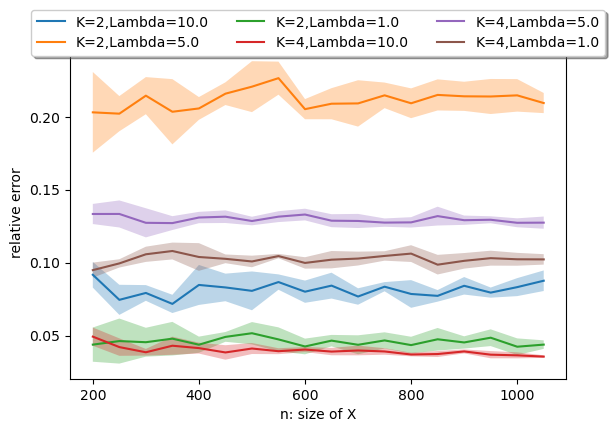

done


In [22]:


fig = plt.figure()
ax = plt.subplot(111)
for K in [2,4]:
    print('K,',K)
    save_dict2=torch.load('experiment/performance/cost_list_K'+str(K)+ '.pt')
    for Lambda in Lambda_list:
        print('Lambda,',Lambda)
        opt_cost1=save_dict2['Lambda'+str(Lambda)]['opt_cost1']
        opt_cost2=save_dict2['Lambda'+str(Lambda)]['opt_cost2']
    #   opt_cost3=save_dict['Lambda'+str(Lambda)]['opt_cost3']

        relative_error1=(np.abs(opt_cost2-opt_cost1)/opt_cost1).mean(2)
        relative_error1_mean=relative_error1.mean(1)
        relative_error1_std=relative_error1.std(1)
        #relative_error2=np.abs(opt_cost3-opt_cost1)/opt_cost1
        #relative_error2_mean=relative_error2.mean(1)
        #relative_error2_std=relative_error2.std(1)

        plt.plot(n_list,relative_error1_mean,'-',label='K='+str(K)+',Lambda='+str(Lambda))
        plt.fill_between(n_list,relative_error1_mean-1*relative_error1_std,relative_error1_mean+1*relative_error1_std,alpha=0.3)
        #plt.plot(n_list,relative_error2_mean,'-',label='b,Lambda='+str(Lambda))
        #plt.fill_between(n_list,relative_error2_mean-1*relative_error2_std,relative_error2_mean+1*relative_error2_std,alpha=0.3)


plt.xlabel("n: size of X")
plt.ylabel("relative error")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.13),
          fancybox=True, shadow=True, ncol=3)
plt.savefig('experiment/performance/error.pdf',format="pdf",dpi=800,bbox_inches='tight')
plt.show()
print('done')

In [57]:
def lot_embedding(X0,X1,p0,p1):
    C=cost_matrix_d(X0,X1)
    gamma=ot.emd(p0,p1,C) # exact linear program
    N0,d=X0.shape
    X1_hat=gamma.dot(X1)/np.expand_dims(p0,1)
    U1=X1_hat-X0
    return U1

def vector_norm(U1,p0):
    norm2=np.sum((U1.T)**2*p1_hat[domain])
    return norm2


# geodesic 
def ot_geodesic(X0,U1,t_list):
    N,d=X0.shape
    tN=t_list.shape[0]
    Xt_list=np.zeros((tN,N,d))
    for i in range(tN):
        t=t_list[i]        
        Xt_list[i]=X0+t*U1        
    return Xt_list
    
def lot_geodesic(X0,U1,U2,t_list):
    N,d=X0.shape
    tN=t_list.shape[0]
    Xt_list=np.zeros((tN,N,d))
    for i in range(tN):
        t=t_list[i]
        Ut=(1-t)*U1+t*U2
        Xt_list[i]=X0+Ut
    return Xt_list

def opt_geodesic(X0,U1,p0,p1_hat,t_list):
    N,d=X0.shape
    tN=t_list.shape[0]
    Xt_list=np.zeros((tN,N,d))
    
    D=p1_hat>0
    
    for i in range(tN):
        t=t_list[i]
        Ut=t*U1
        Xt_list[i]=X0+Ut
    Xt_list=Xt_list[:,D,:]
    X_d=X0[np.invert(D)]
    return Xt_list,X_d

def lopt_geodesic(X0,U1,U2,p1_hat,p2_hat,t_list):
    N,d=X0.shape
    tN=t_list.shape[0]
    Xt_list=np.zeros((tN,N,d))
    
    p12_hat=np.minimum(X0,X1)
    D1=p1_hat>0
    D2=p2_hat>0
    D=p12_hat>0
    
    D_d=np.logical_and(D1, np.invert(D))
    D_c=np.logical_and(D2, np.invert(D)) # domain of desrtoyed point
    
    
    X_d=(X0+U1)[D_d]
    X_c=(X0+U2)[D_c]
    for i in range(tN):
        t=t_list[i]
        U_t=(1-t)*U1+t*U2
        Xt_list[i]=X0+Ut
    Xt_list=Xt_list[:,D,:]
 
    return Xt_list,X_d,X_c

# def lopt_geodesic(X0,Ui,Uj,alpha):
#     n,d=Xi.shape
#     cost,gamma,penualty=opt_lp(X0,Xi,p0,p1,Lambda)
# #   cost,plan=opt_pr()
#     n=X0.shape[0]
#     domain=np.sum(gamma,1)>0
#     p2_hat=np.sum(gamma,1) # martial of plan 
#     # compute barycentric projetion 
#     # (Xi_hat, p1_hat) is the barycentric projection 
#     Xj_hat=np.full((n,d),np.inf) # barycentric projection
#     Xj_hat[domain]=gamma.dot(Xj)[domain]/np.expand_dims(p2_hat,1)[domain]
    
#     # separate barycentric into U_i 
#     X_alpha=Xi_hat*(1-alpha)+Xj*alpha

#     return X_alpha

In [58]:
n_list=range(2000,6000,500)
time_list1=[[],[]]
time_list2=[[],[]]
Lambda_list=[5,25.0]


for n in n_list:
    Xi=np.random.uniform(-20,20,(n,2))+0
    Xj=np.random.uniform(-20,20,(n,2))+30
    p0=np.ones(n)/n
    p1=np.ones(n)/n
    p2=np.ones(n)/n
    for i in range(2):
#        print('start')
        Lambda=Lambda_list[i]
        start_time=time.time()
        opt_lp(Xi,Xj,p1,p2,Lambda,numItermax=200000,numberThreds=1)
        end_time=time.time()
        time_list1[i].append(end_time-start_time)
    
    
        start_time=time.time()
        opt_lp(Xi,Xj,p1,p2,Lambda,numItermax=200000,numberThreds=10)
        end_time=time.time()
        time_list2[i].append(end_time-start_time)
    

time_list={} 
time_list['1']=time_list1
time_list['2']=time_list2

torch.save(time_list,'experiment/performance/time_list.pt')

fig = plt.figure()
ax = plt.subplot(111)

for i in range(2):
    plt.semilogy(n_list,time_list1[i],label='numberThreds=1 $\lambda=$'+str(Lambda_list[i]))
    plt.semilogy(n_list,time_list2[i],label='numberThreds=1 $\lambda=$'+str(Lambda_list[i]))

plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.23),
          fancybox=True, shadow=True, ncol=3)
plt.xlabel('n: size of X')
plt.ylabel("wall time")
#plt.savefig('experiment/test/results/time_numba.png',format='png',dpi=800,bbox_inches='tight')
#plt.title('wall-clock time with accelaration')
plt.show()
    




TypeError: opt_lp() got an unexpected keyword argument 'numberThreds'

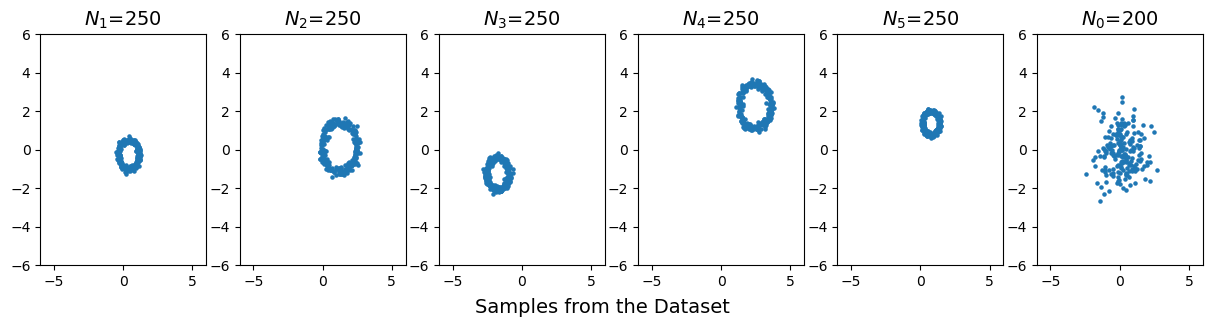

In [161]:
# generate data
data_path='experiment/geodesic/data'
N=200
M=100 # Number of data samples
data_list={}
X0=np.random.randn(N,2)

X=list()
#X.append(X0)
for i in range(M):
    #data,y=make_circles(n_samples=int(50*np.random.rand()+50),noise=.1,factor=.95)
    data,y=make_circles(n_samples=int(N+50),noise=.1,factor=.95)
    #data,y=make_circles(n_samples=int(N+50),noise=.1,factor=.95)
    data=(np.random.rand()+.5)*data+2*np.random.randn(1,2)
    X.append(data)

k=5
fig,ax=plt.subplots(1,k+1,figsize=(k*3,3))
for i in range(k):
    ax[i].scatter(X[i][:,0],X[i][:,1],s=5)
    ax[i].set_title(r'$N_%d$=%d'%(i+1,X[i].shape[0]),fontsize=14)
    ax[i].set_xlim(-6,6)
    ax[i].set_ylim(-6,6)

ax[k].scatter(X0[:,0],X0[:,1],s=5)
ax[k].set_title(r'$N_%d$=%d'%(0,X0.shape[0]),fontsize=14)
ax[k].set_xlim(-6,6)
ax[k].set_ylim(-6,6)

fig.text(0.5, -0.05, 'Samples from the Dataset', ha='center',fontsize=14)
plt.show()

data_list['X0']=X0
data_list['X_0']=X
torch.save(data_list,data_path+'/data_list.pt')

100
200
X0
X_0
X_0.05
X_0.1
save data


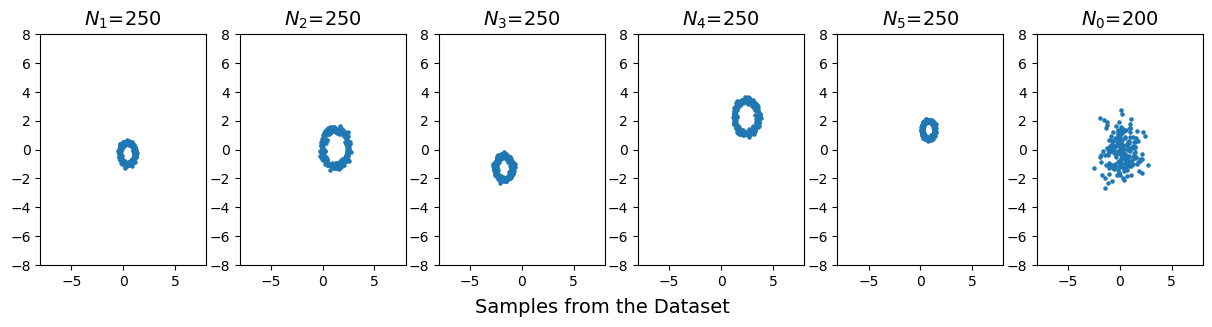

done


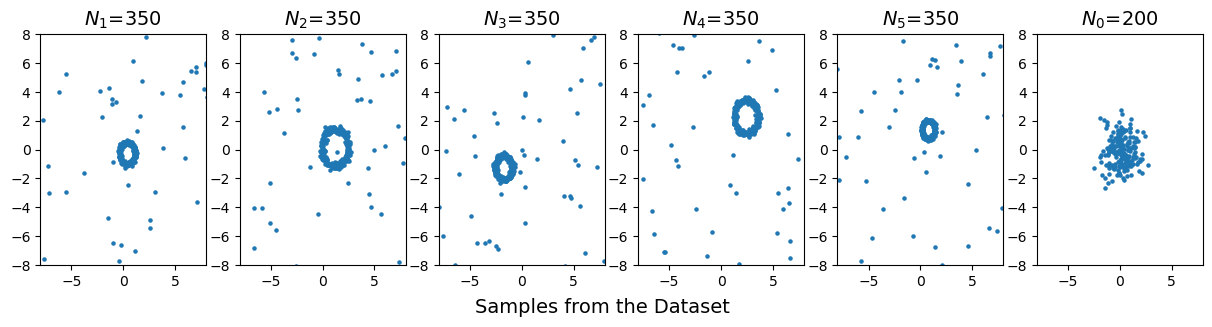

done


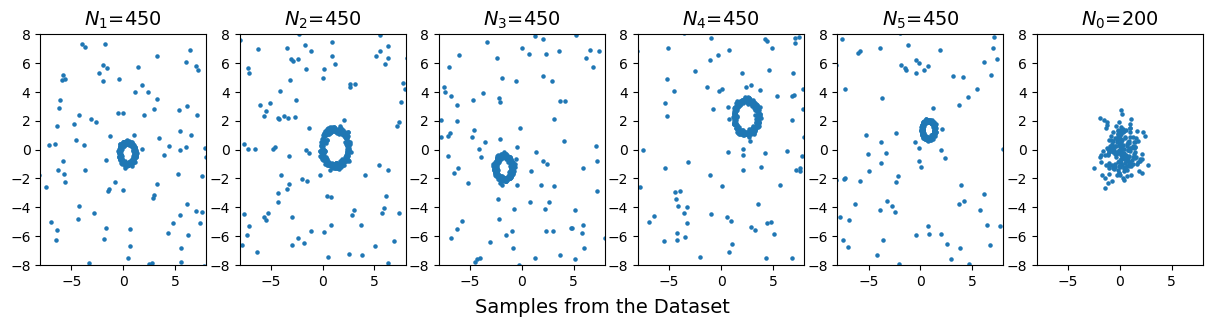

done


In [162]:
data_list=torch.load(data_path+'/data_list.pt')
X=data_list['X_0']
X0=data_list['X0']
for per in [0.05,0.1]:
    X_noise=list()
    n_noise=int(n*per)
    print(n_noise)
    for i in range(M):
        Xi=X[i]
        noise_i=np.random.uniform(low=[-6*2,-6*2],high=[6*2,6*2],size=(n_noise,2))
        X_hat_i=np.concatenate((Xi,noise_i))
        X_noise.append(X_hat_i)
    data_list['X_'+str(per)]=X_noise
torch.save(data_list,data_path+'/data_list.pt')

for key in data_list:
    print(key)
print('save data')

for per in [0,0.05,0.1]:
    k=5
    X=data_list['X_'+str(per)]
    
    fig,ax=plt.subplots(1,k+1,figsize=(k*3,3))
    for i in range(k):
        ax[i].scatter(X[i][:,0],X[i][:,1],s=5)
        ax[i].set_title(r'$N_%d$=%d'%(i+1,X[i].shape[0]),fontsize=14)
        ax[i].set_xlim(-8,8)
        ax[i].set_ylim(-8,8)
    ax[k].scatter(X0[:,0],X0[:,1],s=5)
    ax[k].set_title(r'$N_%d$=%d'%(0,X0.shape[0]),fontsize=14)
    ax[k].set_xlim(-8,8)
    ax[k].set_ylim(-8,8)
    fig.text(0.5, -0.05, 'Samples from the Dataset', ha='center',fontsize=14)
    plt.show()
    print('done')


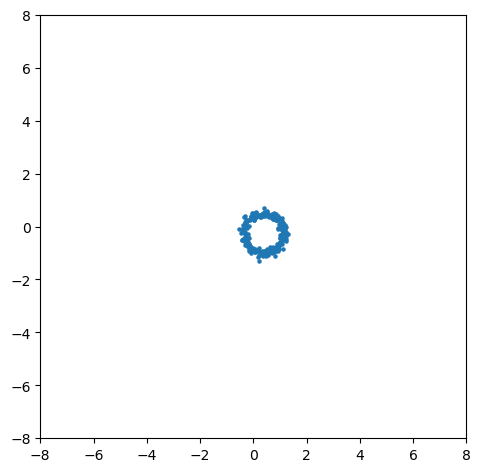

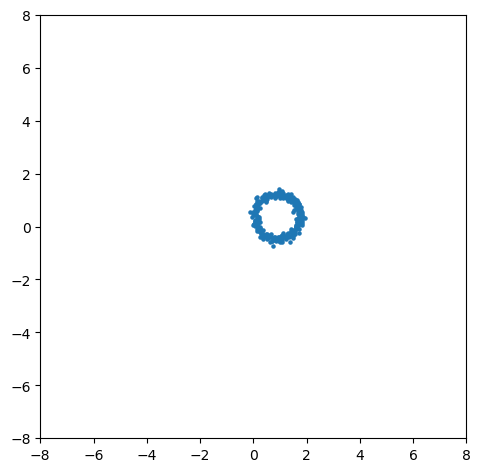

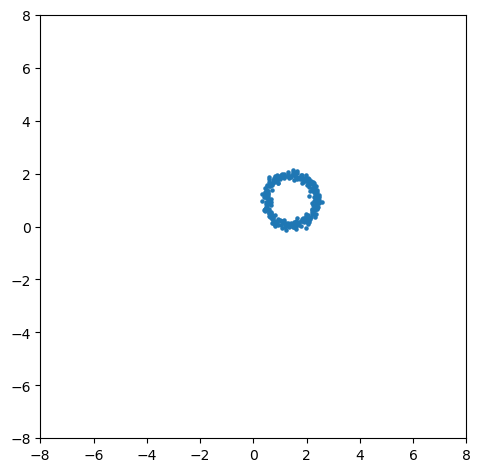

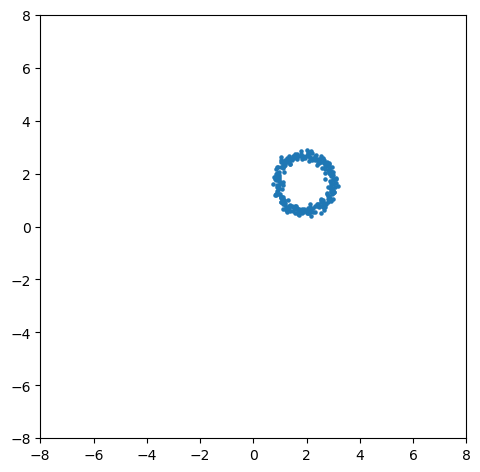

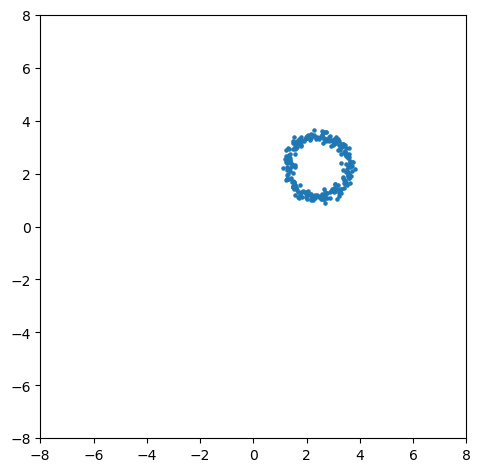

done


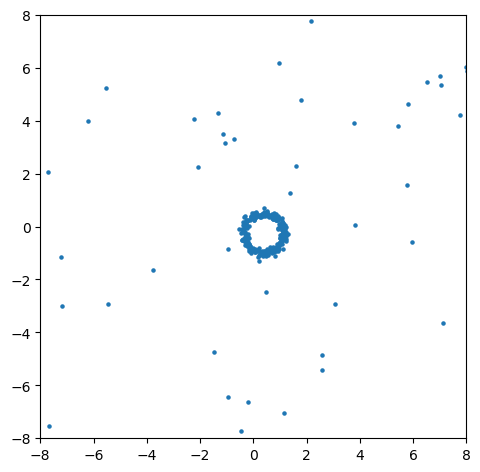

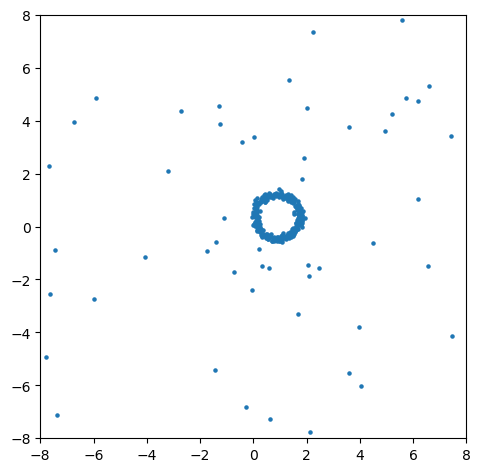

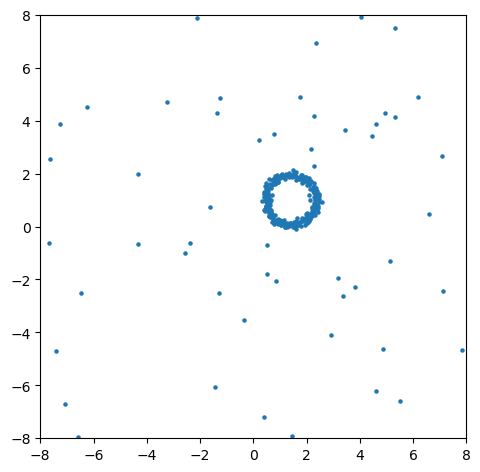

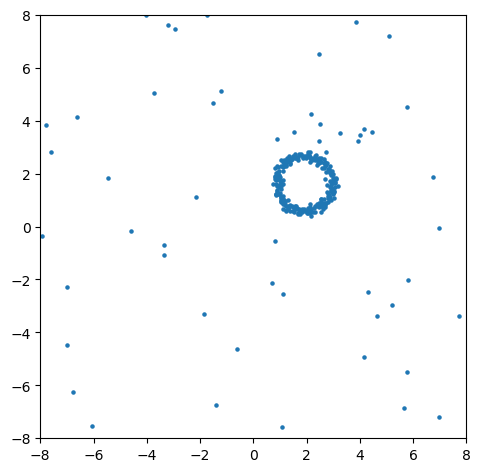

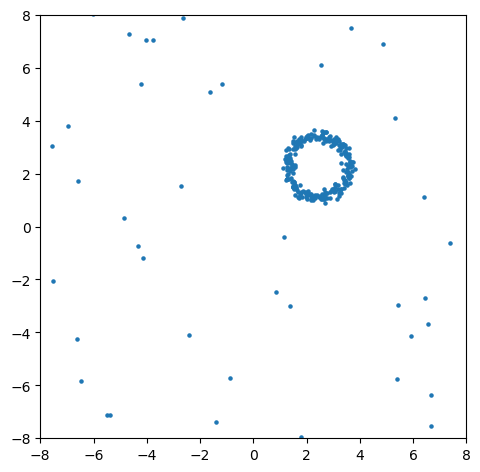

done


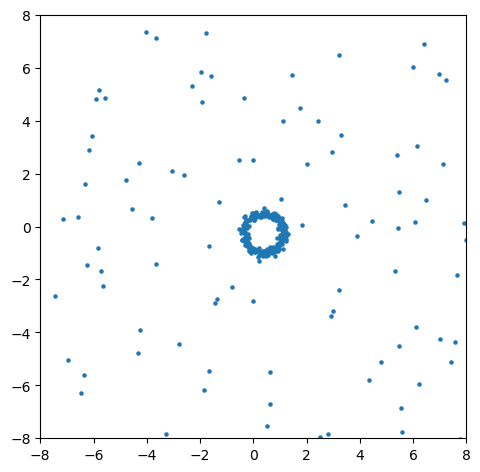

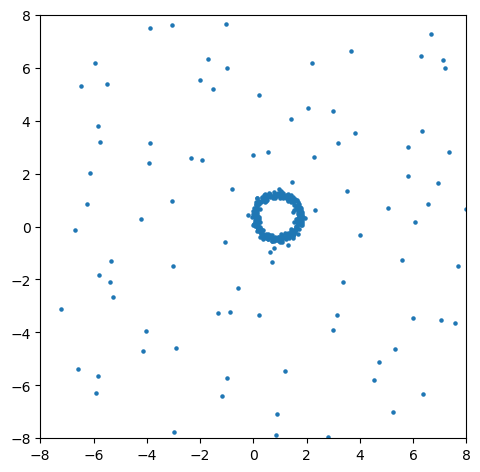

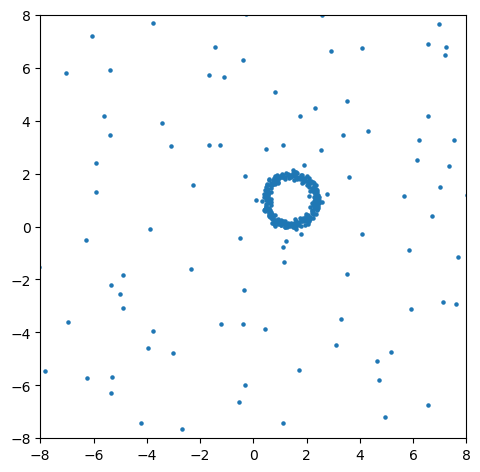

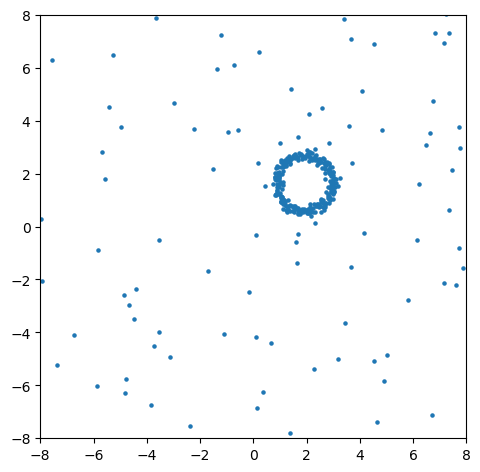

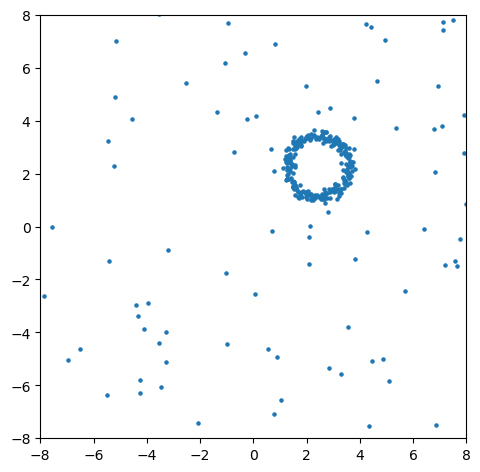

done


In [169]:
# OT geodesic
k=5
i=0
j=3
#fig,ax=plt.subplots(1,k,figsize=(k*3,3))
for label in [0,0.05,0.1]: 
    save_path='experiment/geodesic/result/'+str(label)
    X=data_list['X_'+str(label)]
    Xi=X[i].copy()
    Xj=X[j].copy()
    X0=data_list['X0'].copy()
    pi=np.ones(Xi.shape[0])/Xi.shape[0]
    pj=np.ones(Xj.shape[0])/Xj.shape[0]
    Uj=lot_embedding(Xi,Xj,pi,pj)
    Xt_list_ot=ot_geodesic(Xi,Uj,np.linspace(0,1,k))
    
    ind=0
    for t in np.linspace(0,1,k):
        Xt=Xt_list_ot[ind]
        name='X_ot_t='+str(alpha)
        plt.figure(1, figsize=(5.5,5.5))
        plt.scatter(Xt[:,0], Xt[:,1], s=5, alpha=1)
        plt.xlim(-8,8)
        plt.ylim(-8,8)
        plt.savefig(save_path+'/'+name+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
        plt.show()
        ind+=1
    torch.save(Xt_list_ot,save_path+'/Xt_list_ot.pt')
    print('done')

#ax[i].scatter(X_alpha[:,0],X_alpha[:,1],s=5,alpha=1)
#ax[i].set_title(r'$\alpha=$%.02f'%alpha,fontsize=14)
#ax[i].set_xlim(-6,6)
#ax[i].set_ylim(-6,6)    
# fig.text(0.5, -0.05, 'Transport Geodesic, OT', ha='center',fontsize=14)
# plt.show()

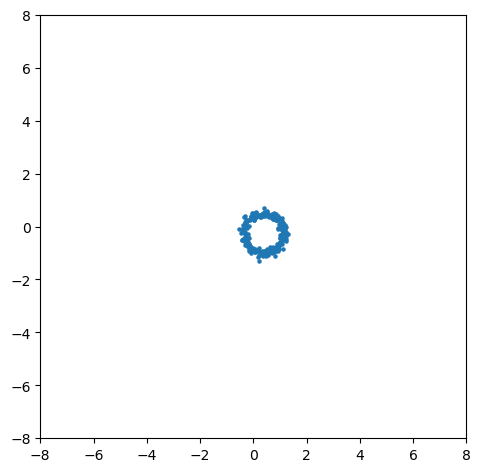

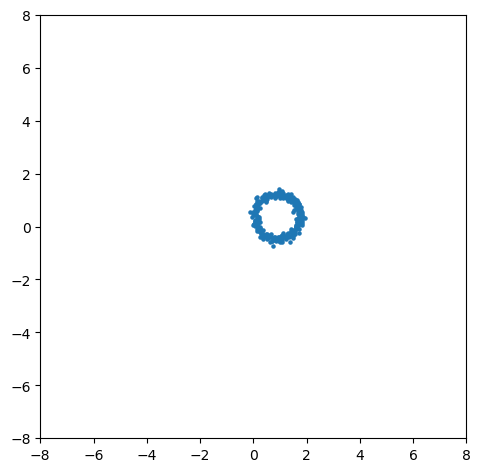

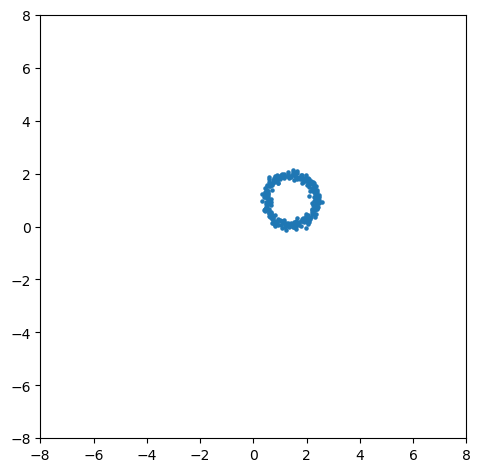

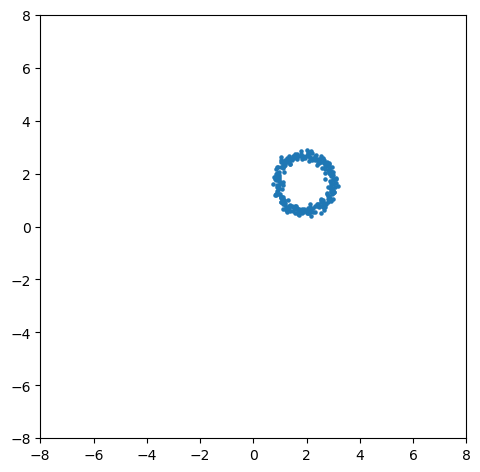

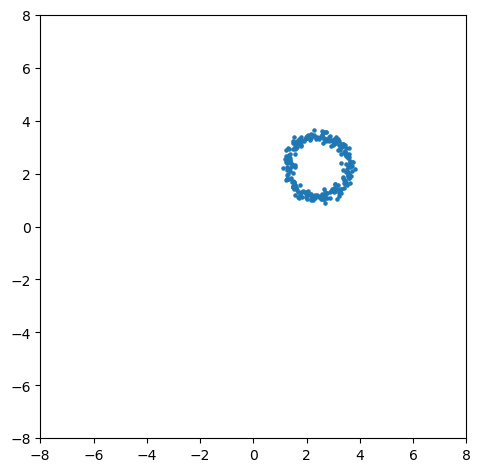

end


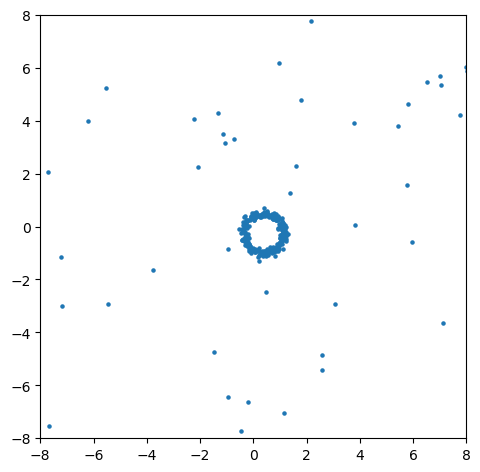

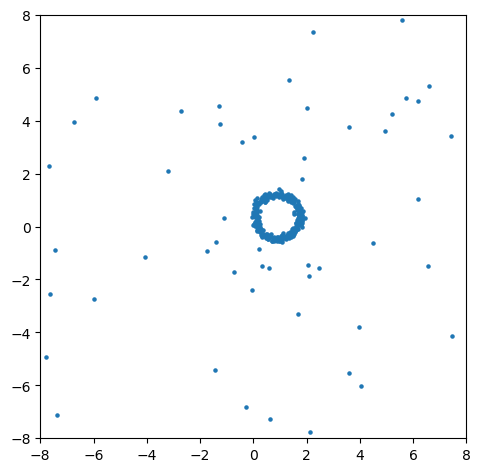

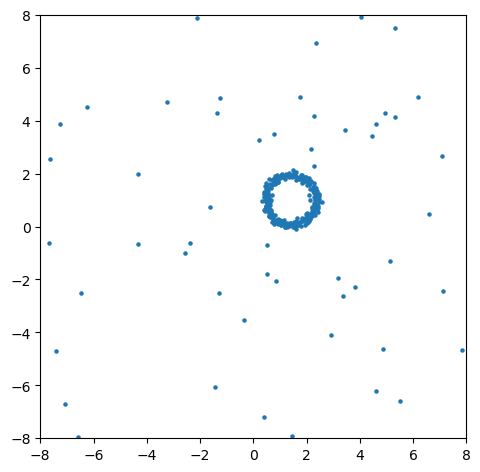

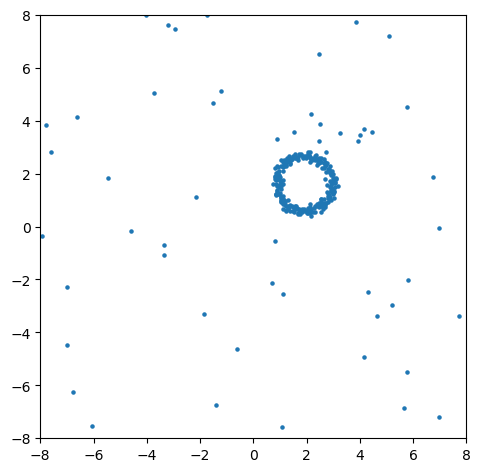

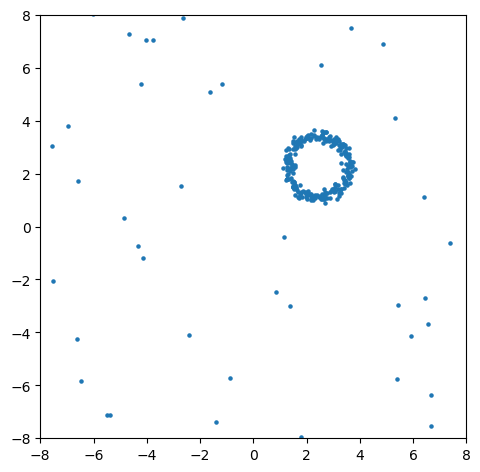

end


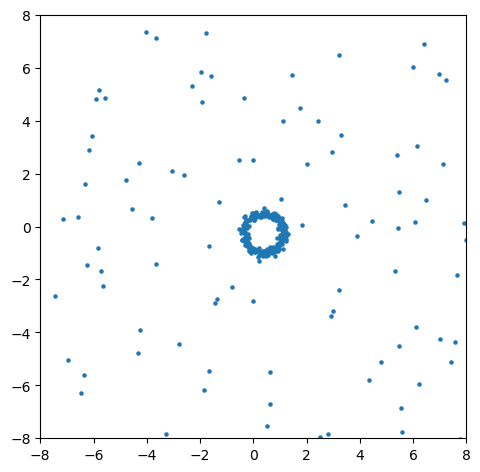

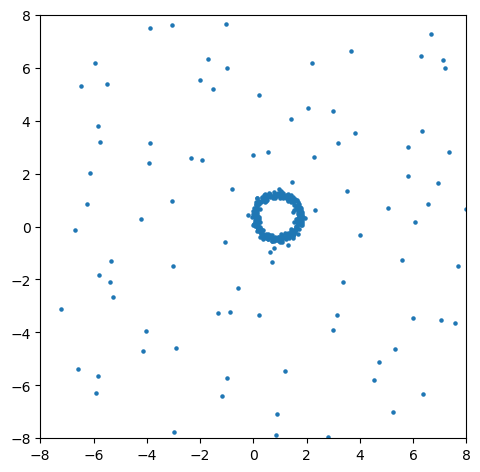

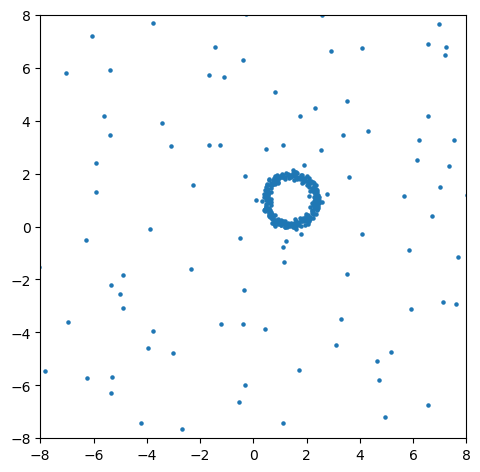

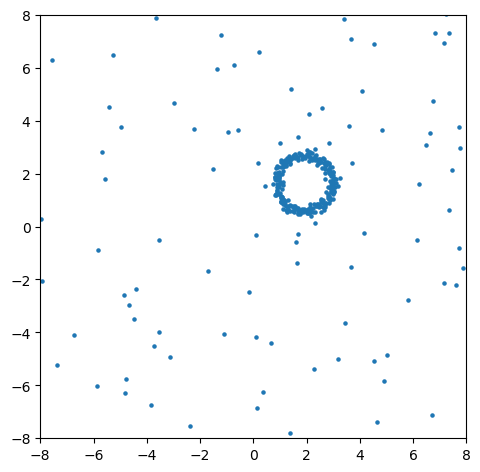

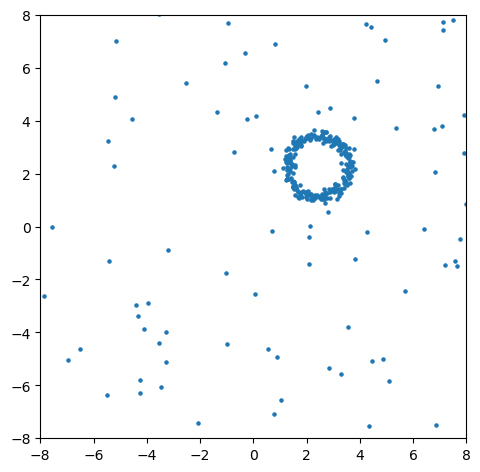

end


In [178]:
#result_path='experiment/geodesic/result/'+str(per)
# LOT geodesic

for label in [0,0.05,0.1]: 
    save_path='experiment/geodesic/result/'+str(label)
    X=data_list['X_'+str(label)]
    Xi=X[i].copy()
    Xj=X[j].copy()
    X0=data_list['X0'].copy()
    U_lot=list()
    for k in range(M):
        X0=X[0].copy()
        Xk=X[k].copy()
        N0=X0.shape[0]
        Nk=Xk.shape[0]
        p0=np.ones(N0)/N0
        pk=np.ones(Nk)/Nk
        Uk_lot=lot_embedding(X0,Xk,p0,pk)
        U_lot.append(Uk_lot)
    torch.save(U_lot,save_path+'/U_lot.pt')

    k=5
    Ui=U_lot[i]
    Uj=U_lot[j]
    
    #X_alpha=lot_geodesic(X0,Ui,Uj,alpha)
    
    Xt_list_lot=lot_geodesic(X0,Ui,Uj,np.linspace(0,1,k))
    ind=0
    for t in np.linspace(0,1,k):
        Xt=Xt_list_lot[ind]
        plt.figure(1, figsize=(5.5,5.5))
        name='X_lot_t='+str(t)
        plt.scatter(Xt[:,0], Xt[:,1], s=5, alpha=1)
        plt.xlim(-8,8)
        plt.ylim(-8,8)
        plt.savefig(save_path+'/'+name+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
        plt.show()
        ind+=1   
    torch.save(Xt_list_lot,save_path+'/Xt_list_lot.pt')
     
        #print(save_path+'/U_ot.pt')
    print('end')

    

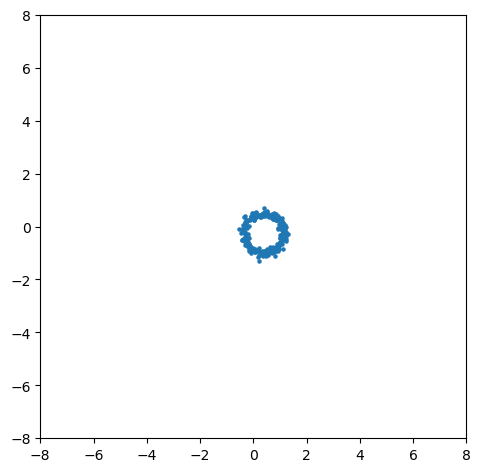

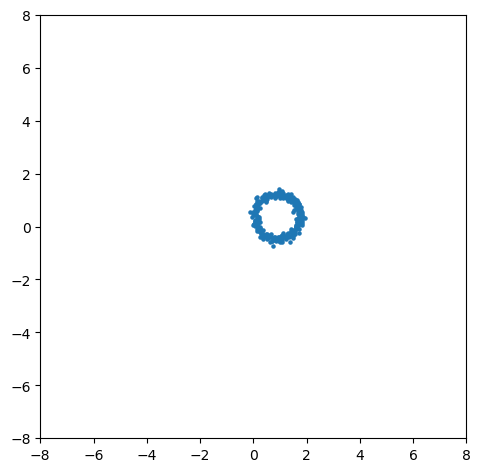

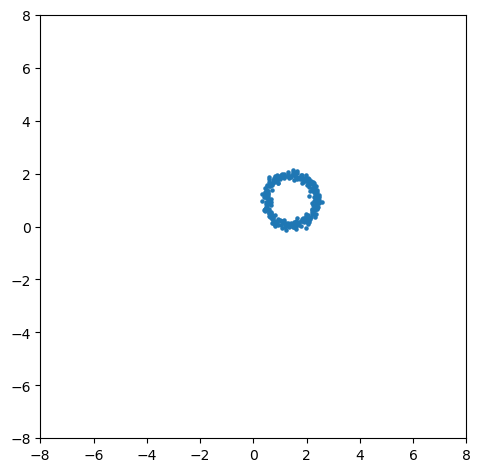

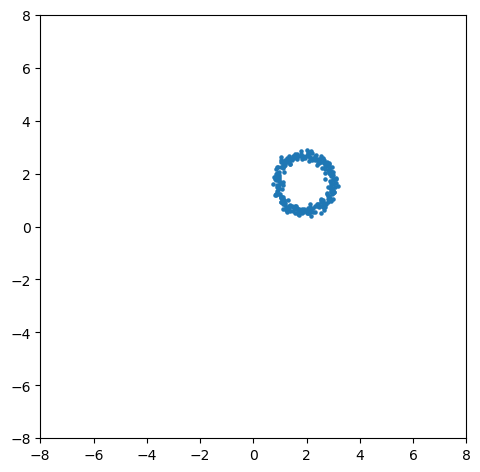

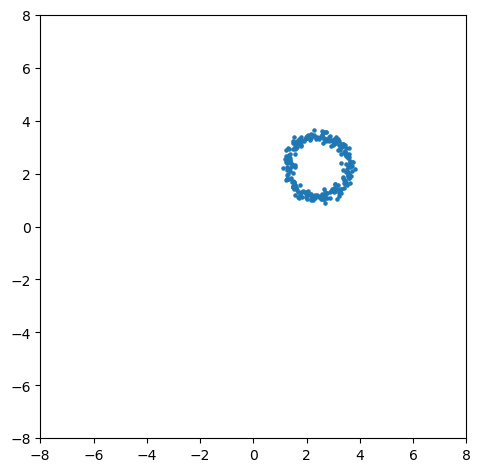

end


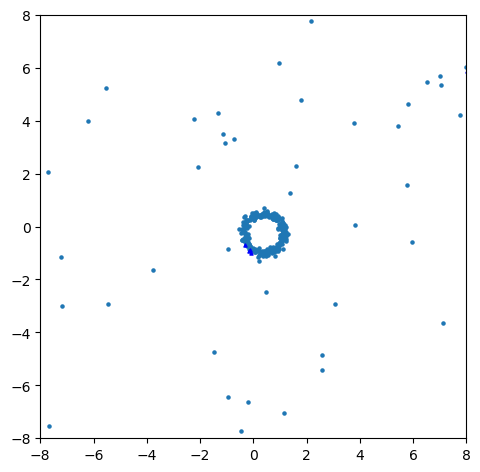

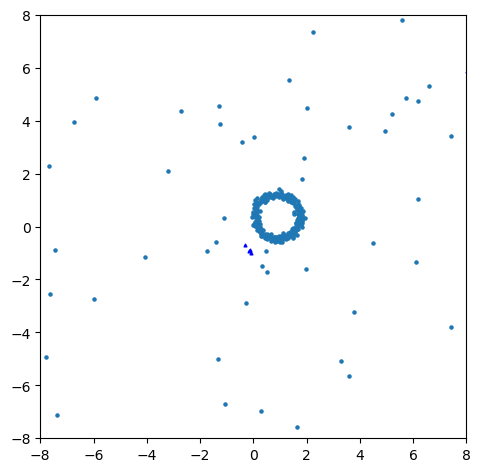

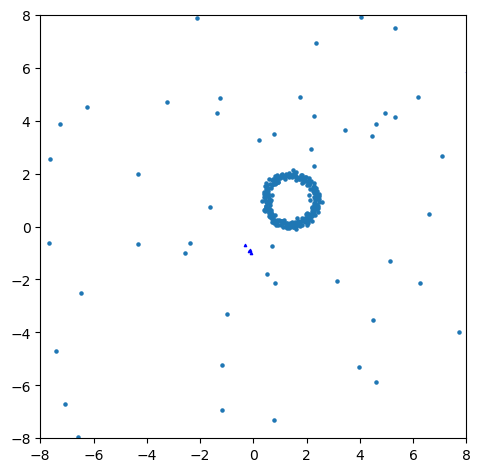

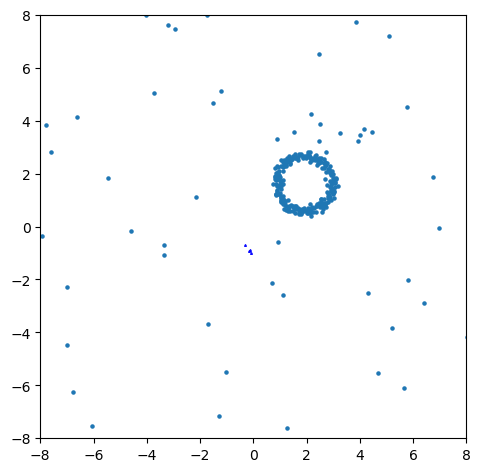

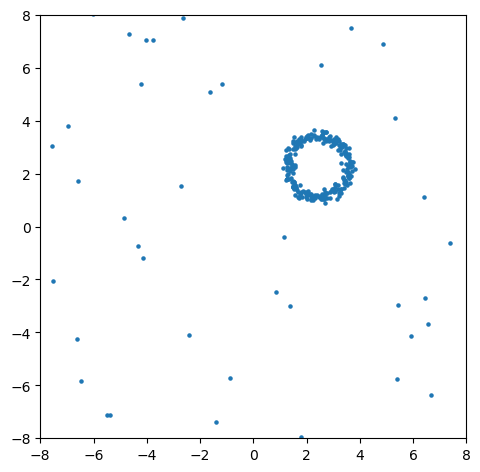

end


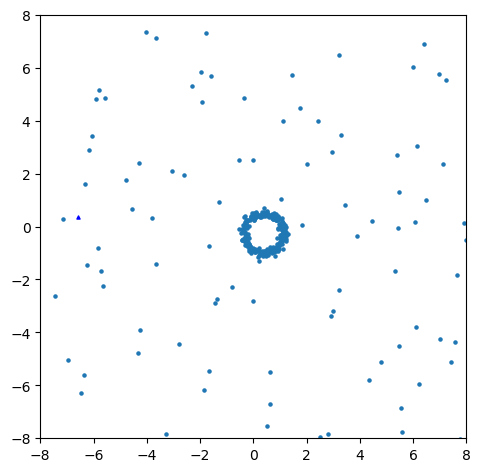

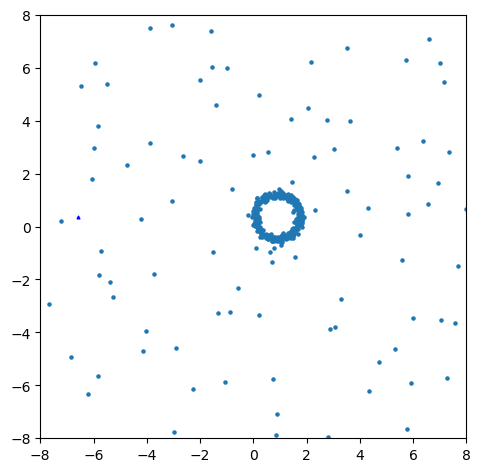

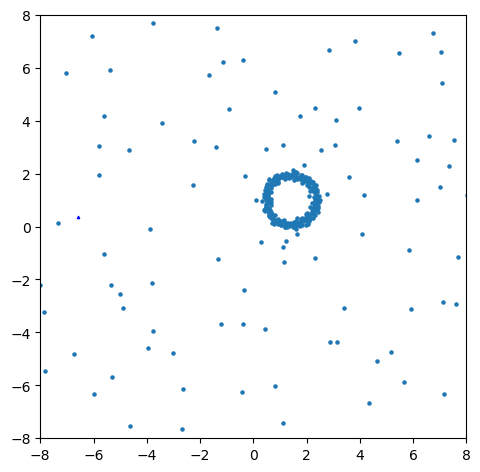

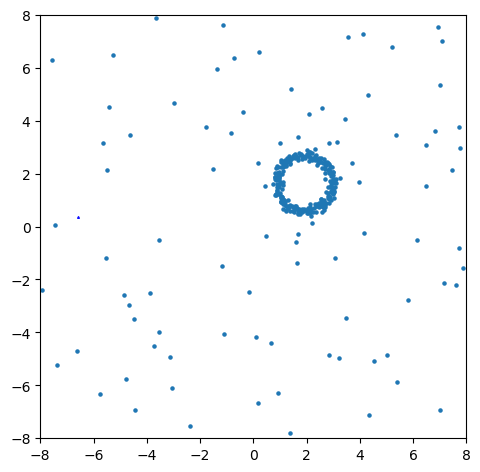

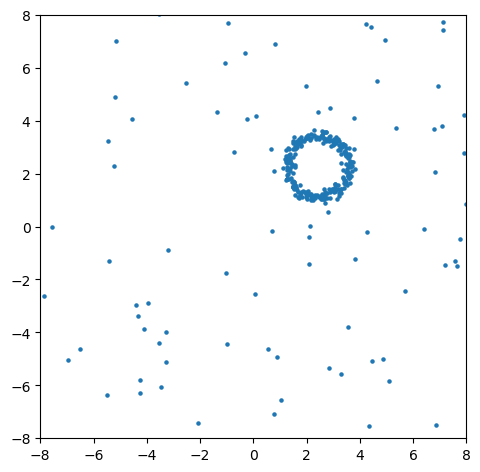

end


In [180]:
# opt interpolation 

for label in [0,0.05,0.1]: 
    save_path='experiment/geodesic/result/'+str(label)
    X_0=data_list['X_0']
    X0i=X_0[i]
    X0j=X_0[j]
    N0i=X0i.shape[0]
    N0j=X0j.shape[0]
    
    X=data_list['X_'+str(label)]
    Xi=X[i].copy()
    Xj=X[j].copy()
    X0=X[0].copy()
    U_ot=list()

    Ni=Xi.shape[0]
    Nj=Xj.shape[0]
    pi=np.ones(Ni)/N0i
    pj=np.ones(Nj)/N0j
    Lambda=25.0

    Uj,pj_hat,Mj=lopt_embedding(Xi,Xj,pi,pj,Lambda)
    Xt_list,X_d=opt_geodesic(Xi,Uj,pi,pj_hat,np.linspace(0,1,k))
    ind=0
    for t in np.linspace(0,1,k): 
        Xt=Xt_list[ind]
        plt.figure(1, figsize=(5.5,5.5))
        name='X_opt_t='+str(t)
        plt.scatter(Xt[:,0], Xt[:,1], s=5, alpha=1)
        plt.scatter(X_d[:,0], X_d[:,1],c='b',marker='^', s=5*(1-t), alpha=1)
        plt.xlim(-8,8)
        plt.ylim(-8,8)
        plt.savefig(save_path+'/'+name+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
        plt.show()
        ind+=1

    torch.save(X_alpha_opt,save_path+'/X_opt_alpha.pt')
    print('end')
    # X_alpha=opt_geodesic(Xi,Xj,p1,p2,Lambda,alpha)
    # ax[i].scatter(X_alpha[:,0],X_alpha[:,1],s=5,alpha=1)
    # ax[i].set_title(r'$\alpha=$%.02f'%alpha,fontsize=14)
    # ax[i].set_xlim(-8,8)
    # ax[i].set_ylim(-8,8)

#i=k
#ax[i].scatter(X_alpha[:,0],X_alpha[:,1],s=5,alpha=1)
#ax[i].set_title(r'$\alpha=$%.02f'%alpha,fontsize=14)
#ax[i].set_xlim(-6,6)
#ax[i].set_ylim(-6,6)    
#fig.text(0.5, -0.05, 'Transport Geodesic, OPT', ha='center',fontsize=14)
#plt.show()

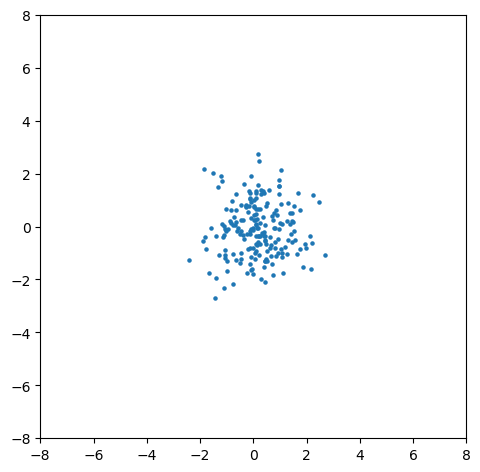

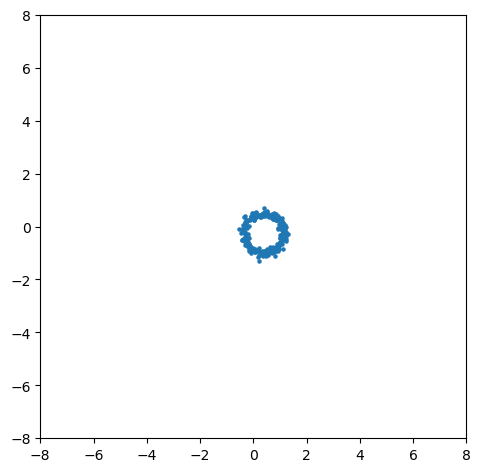

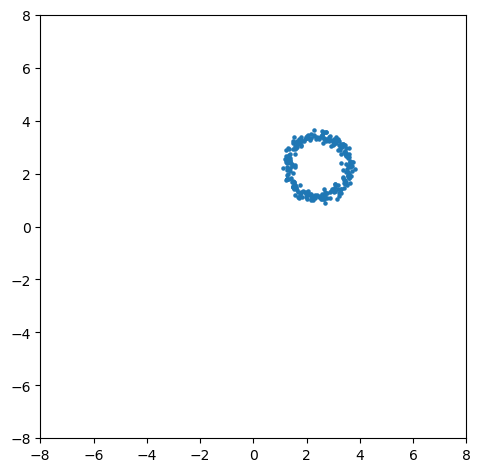

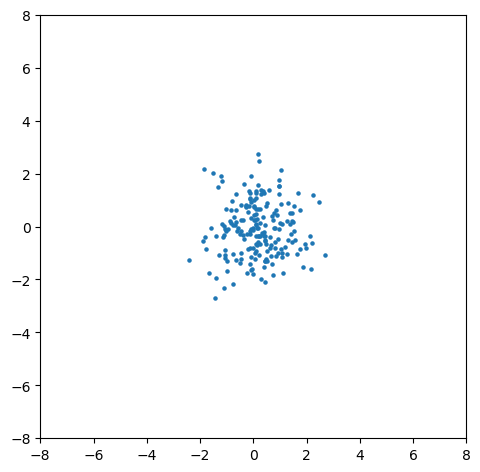

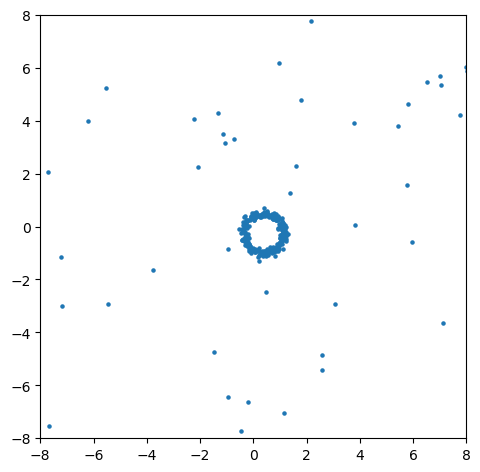

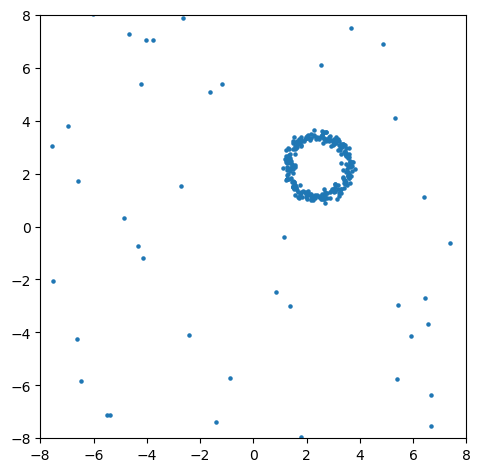

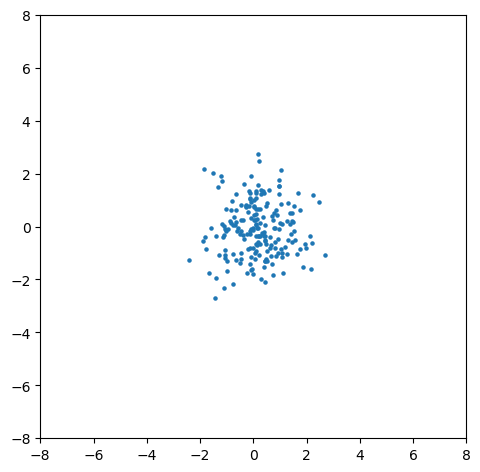

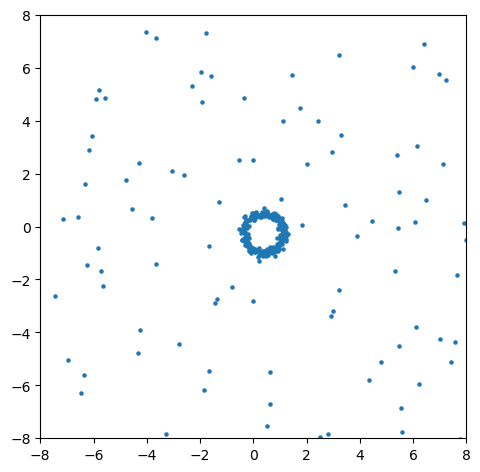

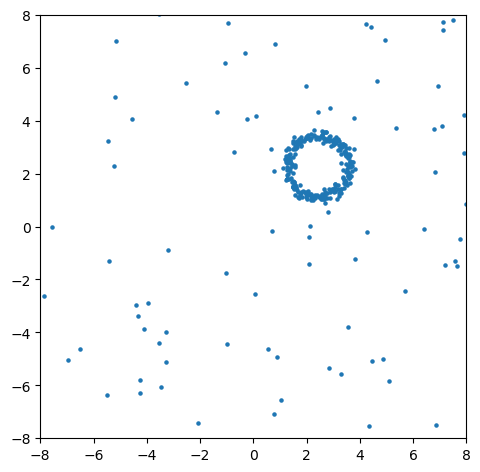

In [181]:
#load data

#print(X0)
for label in [0,0.05,0.1]:
    save_path='experiment/geodesic/result/'+str(label)
    X=data_list['X_'+str(label)]
    Xi=X[i].copy()
    Xj=X[j].copy()
    X0=data_list['X0'].copy()
    
    name='X0'
    plt.figure(1, figsize=(5.5,5.5))    
    plt.scatter(X0[:,0], X0[:,1], s=5, alpha=1)
    plt.xlim(-8,8)
    plt.ylim(-8,8)
    plt.savefig(save_path+'/'+name+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
    plt.show()
        
    for k in [i,j]:
        Xk=X[k].copy()
        name='X'+str(k+1)
        plt.figure(1, figsize=(5.5,5.5))
        
        plt.scatter(Xk[:,0], Xk[:,1], s=5, alpha=1)
        #plt.set_title('Xi',fontsize=14)
        plt.xlim(-8,8)
        plt.ylim(-8,8)
        plt.savefig(save_path+'/'+name+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
        plt.show()

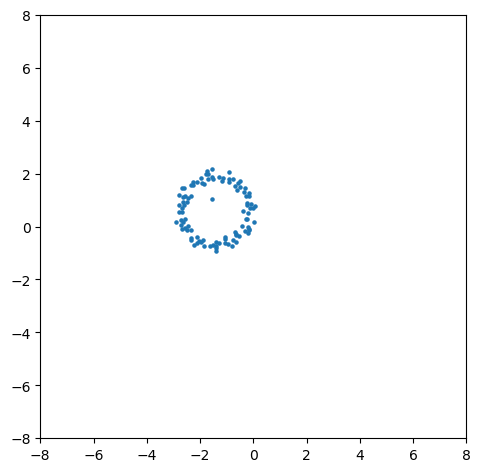

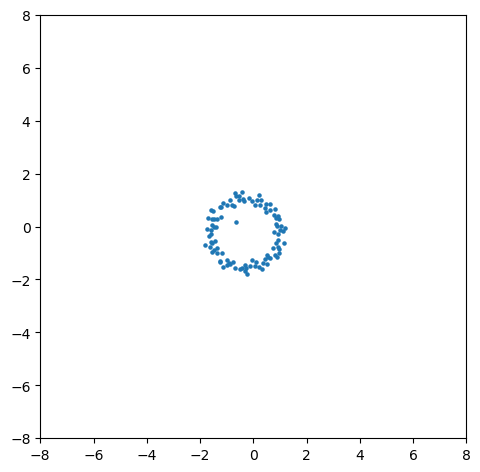

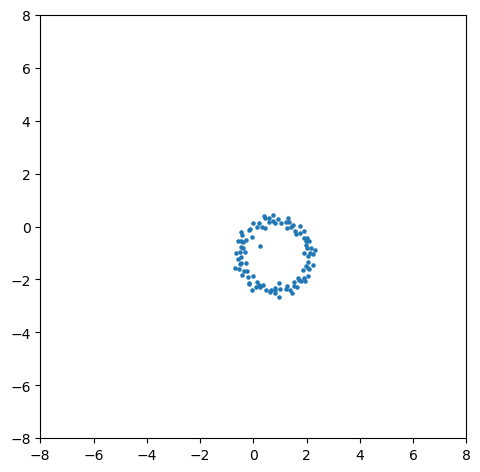

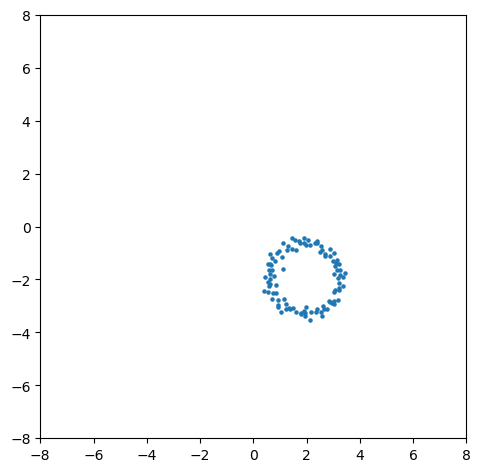

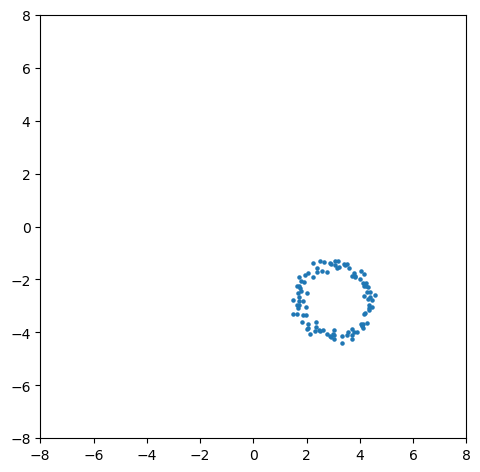

end


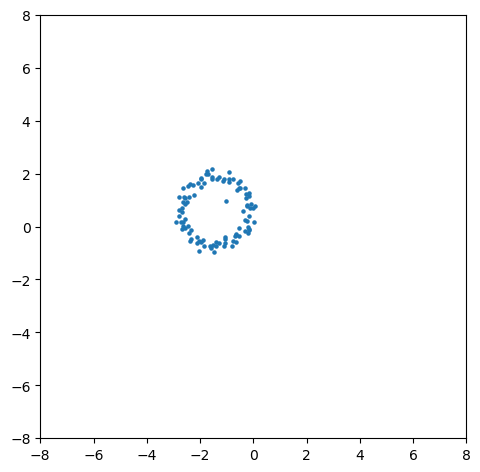

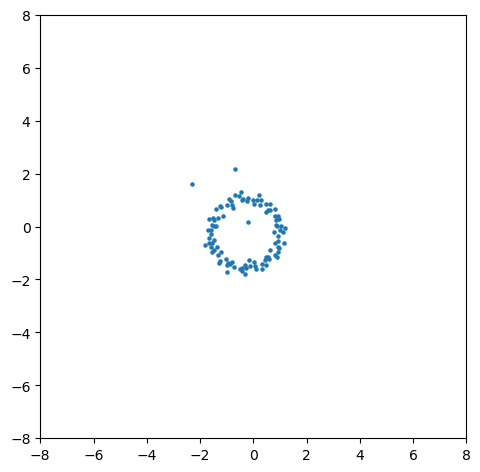

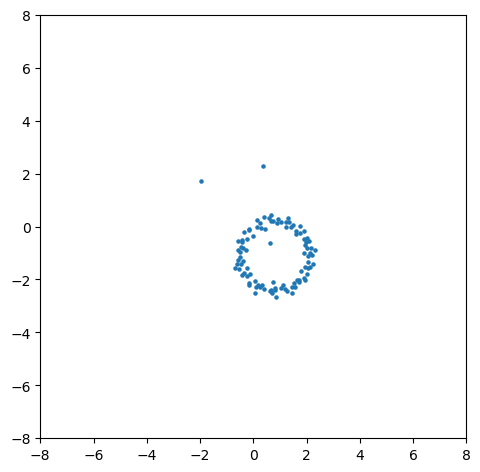

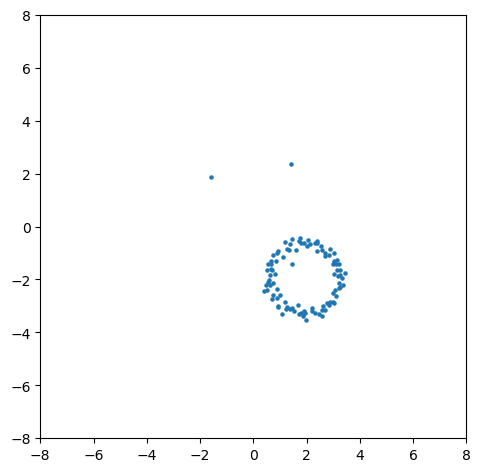

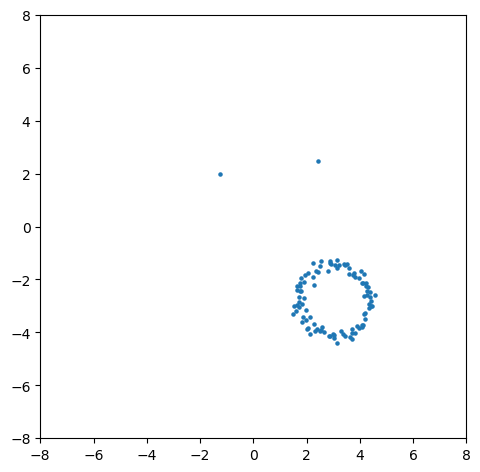

end


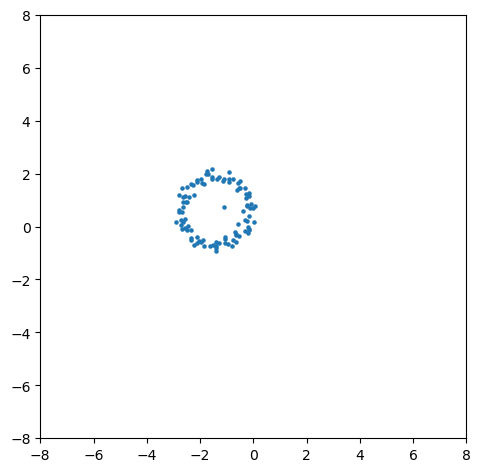

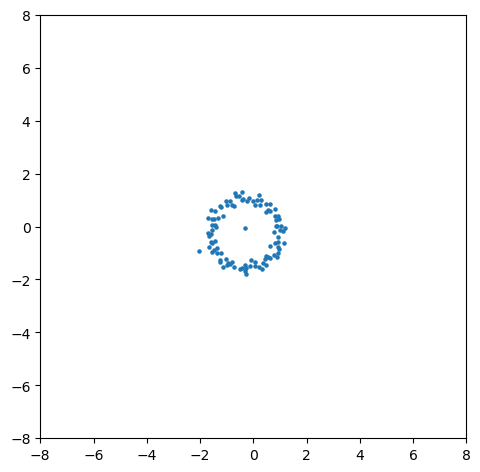

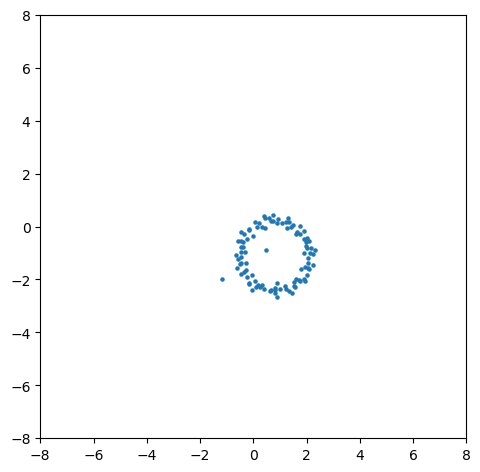

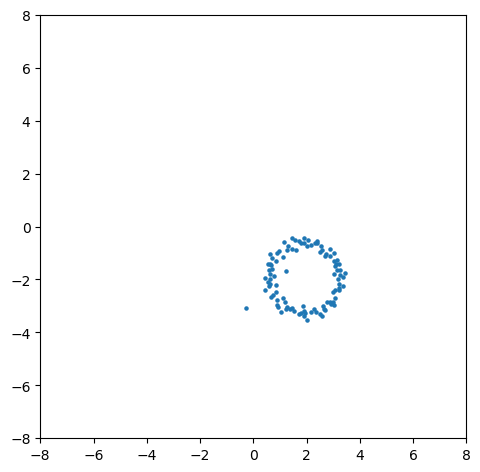

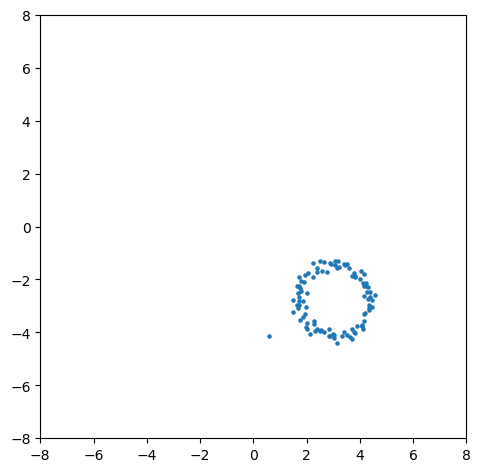

end


In [403]:
# LOPT interpolation 

for label in [0,0.05,0.1]: 
    save_path='experiment/geodesic/result/'+str(label)
    X_0=data['X_0']
    X=data['X_'+str(label)]
    opt_embedding=list()

    X0=data_list['X0'].copy()
    for k in range(M):
        X00=X_0[0]
        X0k=X_0[k]
        N00=X00.shape[0]
        N0k=X0k.shape[0]
        
        
        Xk=X[k].copy()
        N0=X0.shape[0]
        Nk=Xk.shape[0]
        p0=np.ones(N0)/N00
        pk=np.ones(Nk)/N0k
        Uk,pk_hat,Mk=lopt_embedding(X0,Xk,p0,pk,Lambda)
        opt_embedding.append((Uk,pk_hat))
        
    torch.save(opt_embedding,save_path+'/opt_embedding.pt')
    #print(save_path+'/U_opt.pt')
    Lambda=20.0
    Xt_list_lopt,X_d,X_c=lopt_geodesic(X0,Ui,Uj,pi_hat,pj_hat,np.linspace(0,1,k))
    Ui=U_opt[i]
    Uj=U_opt[j]
    pi_hat=p_hat_opt[i]
    pj_hat=p_hat_opt[j]
    
    ind=0
    for t in np.linspace(0,1,k):
        Xt=Xt_list_lopt[ind]
        plt.figure(1, figsize=(5.5,5.5))
        name='X_lopt_alpha='+str(alpha)
        plt.scatter(X_alpha[:,0], X_alpha[:,1], s=5, alpha=1)
        plt.scatter(X_d[:,0], X_d[:,1],color='b',marker='^', s=5*(1-alpha), alpha=1)
        plt.scatter(X_c[:,0], X_c[:,1],color='b',marker='^', s=5*(alpha), alpha=1)

        plt.xlim(-8,8)
        plt.ylim(-8,8)
        plt.savefig(save_path+'/'+name+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
        plt.show()
        ind+=1
    print('end')


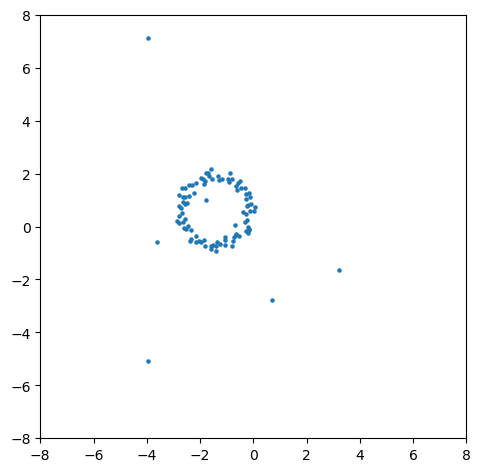

In [401]:
#print((X0+Ui).shape)
plt.figure(1, figsize=(5.5,5.5))
# #name='X_lopt_alpha='+str(alpha)
plt.scatter((X0+Ui)[:,0], (X0+Ui)[:,1], s=5, alpha=1)

plt.xlim(-8,8)
plt.ylim(-8,8)
#plt.savefig(save_path+'/'+name+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
plt.show()

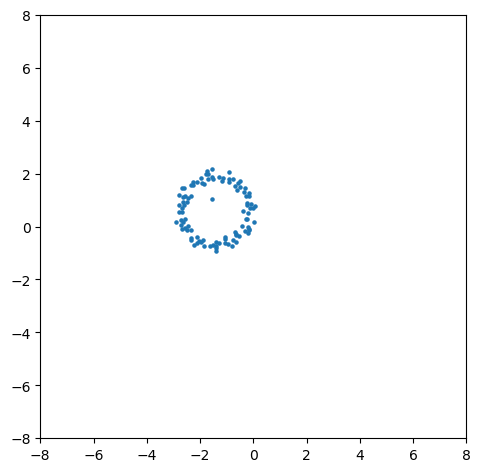

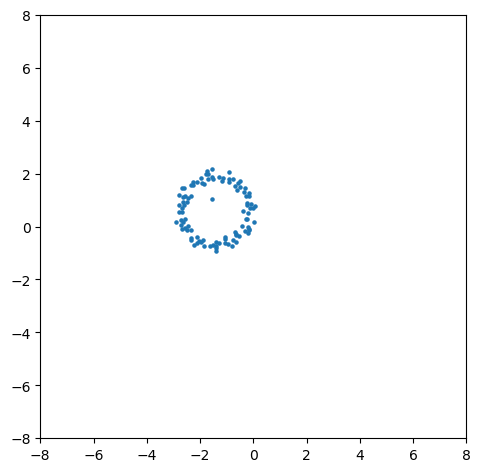

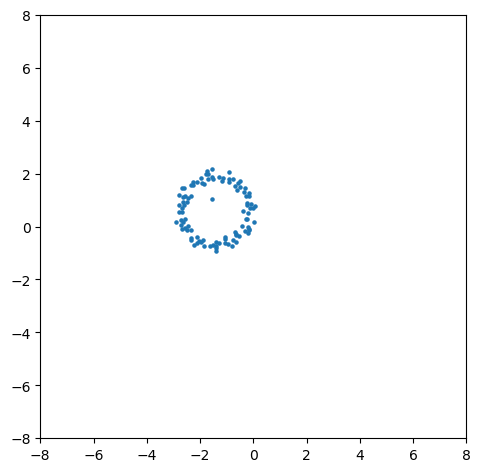

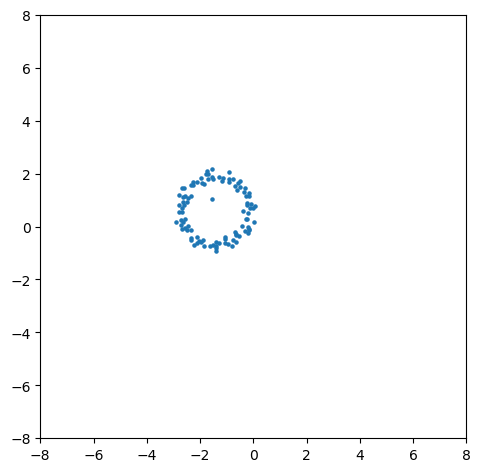

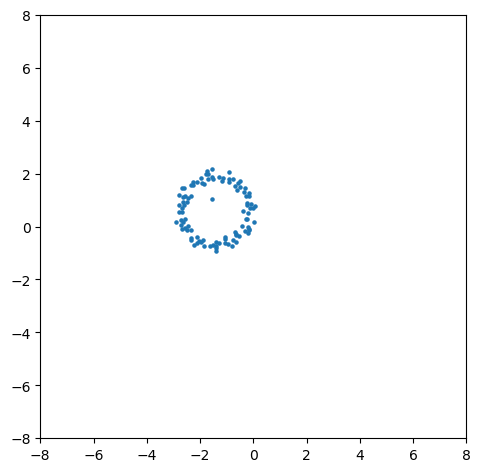

In [277]:
k=5
#fig,ax=plt.subplots(1,k,figsize=(k*3,3))
i=1
j=3
X0=X[0]
Ui=U_opt[i]
Uj=U_opt[j]


Lambda=40.0
X_alpha_lopt=list()
for alpha in np.linspace(0,1,k):
    X_alpha,X_d,X_c=lopt_geodesic(X0,Ui,Uj,alpha)
    X_alpha_lopt.append((X_alpha,X_d,X_c))
    plt.figure(1, figsize=(5.5,5.5))
    name='X_lopt_alpha='+str(alpha)
    plt.scatter(X_alpha[:,0], X_alpha[:,1], s=5, alpha=1)
    plt.scatter(X_d[:,0], X_d[:,1],color='b',marker='^', s=5*(1-alpha), alpha=1)
    plt.scatter(X_c[:,0], X_c[:,1],color='b',marker='^', s=5*(alpha), alpha=1)
    
    plt.xlim(-8,8)
    plt.ylim(-8,8)
    plt.savefig(save_path+'/'+name+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
    plt.show()
    
# for i,alpha in enumerate(np.linspace(0,1,k)):
#     X_alpha,X_d,X_c=lopt_geodesic(X0,Ui,Uj,alpha)
#     ax[i].scatter(X_alpha[:,0],X_alpha[:,1],s=5,alpha=1)
#     ax[i].set_title(r'$\alpha=$%.02f'%alpha,fontsize=14)
#     ax[i].set_xlim(-8,8)
#     ax[i].set_ylim(-8,8)
# i=k
# #ax[i].scatter(X_alpha[:,0],X_alpha[:,1],s=5,alpha=1)
# #ax[i].set_title(r'$\alpha=$%.02f'%alpha,fontsize=14)
# #ax[i].set_xlim(-6,6)
# #ax[i].set_ylim(-6,6)    
# fig.text(0.5, -0.05, 'Transport Geodesic, LOPT', ha='center',fontsize=14)
# plt.show()